First few rows of the dataset:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

   ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 2003-02-24  Shipped       1         2     2003  ...   
1 2003-05-07  Shipped       2         5     2003  ...   
2 2003-07-01  Shipped       3         7     2003  ...   
3 2003-08-25  Shipped       3         8     2003  ...   
4 2003-10-10  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2           CITY STATE  \
0        897 Long Airport Avenue           NaN            NYC    NY   
1             59 rue de l'Abbaye           NaN     

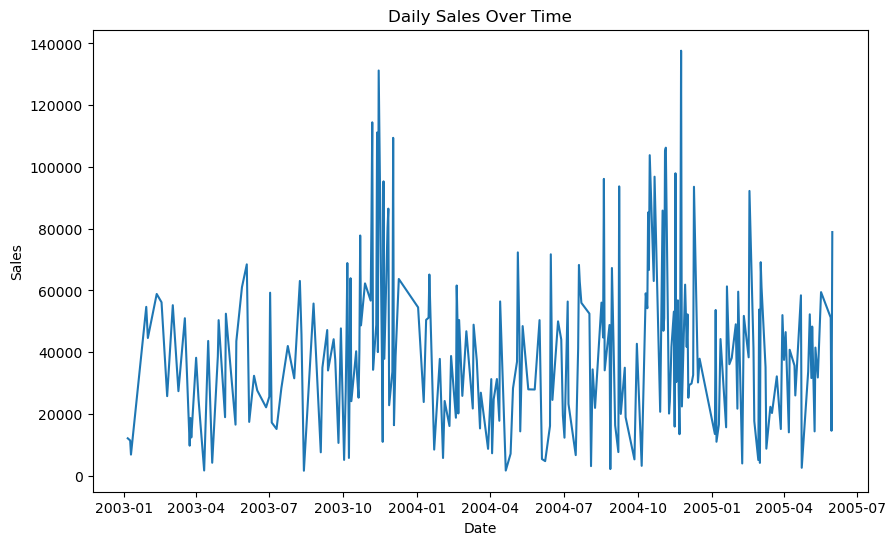

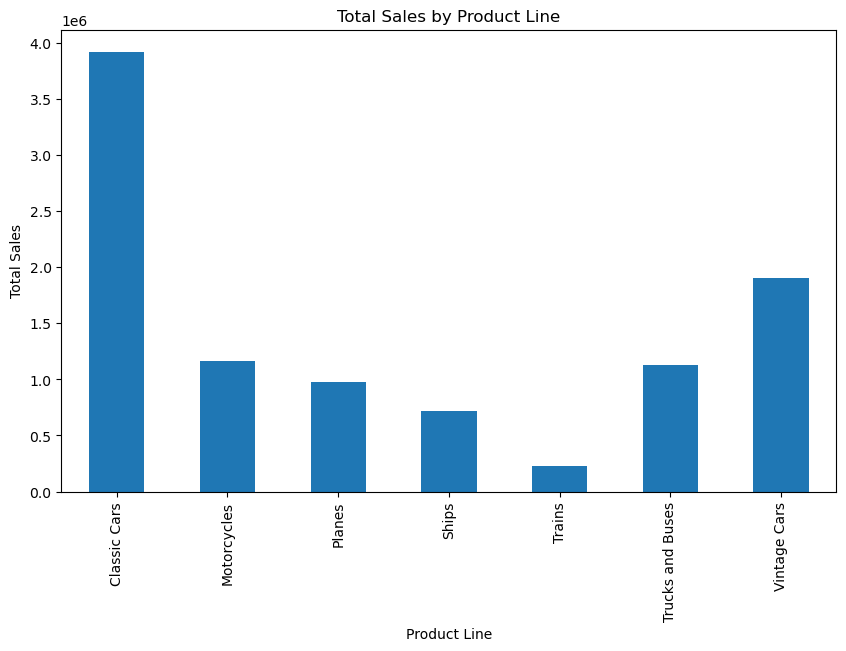

C:\Users\Shaarukesh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Shaarukesh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Shaarukesh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Shaarukesh\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Shaarukesh\anacond

Best ARIMA parameters: (0, 2, 1)
                               SARIMAX Results                                
Dep. Variable:                  SALES   No. Observations:                   17
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -209.442
Date:                Thu, 13 Mar 2025   AIC                            422.885
Time:                        23:10:52   BIC                            424.301
Sample:                    01-31-2003   HQIC                           422.870
                         - 05-31-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9244      0.252     -3.669      0.000      -1.418      -0.431
sigma2      1.102e+11   1.79e-12   6.16e+22      0.000     1.1e+11     1.1e+11
Ljung-Box (L1) (Q):

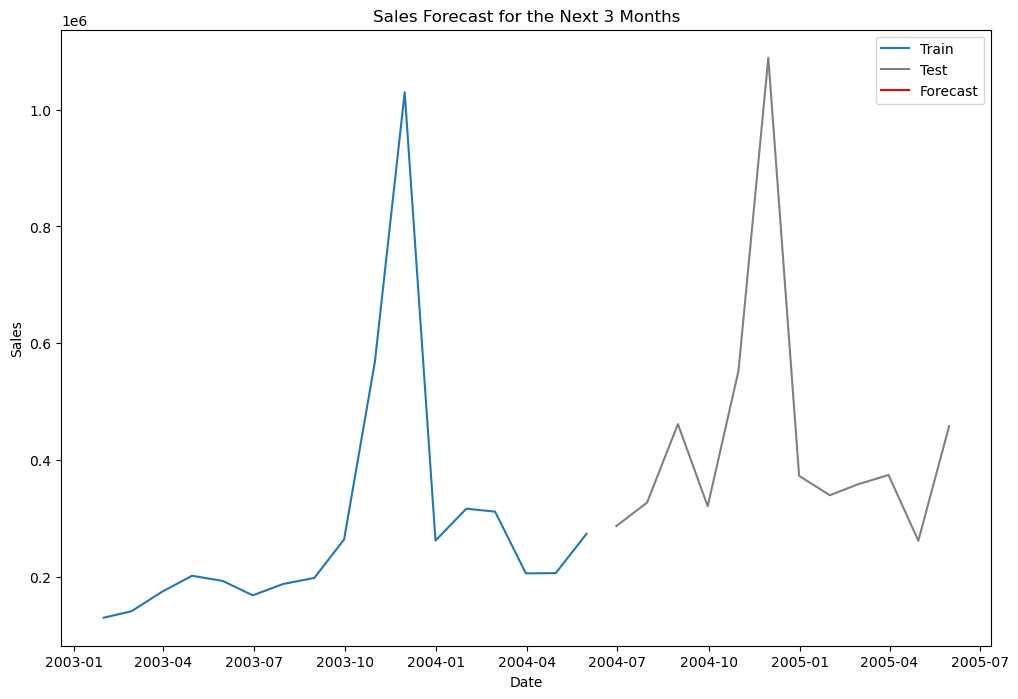

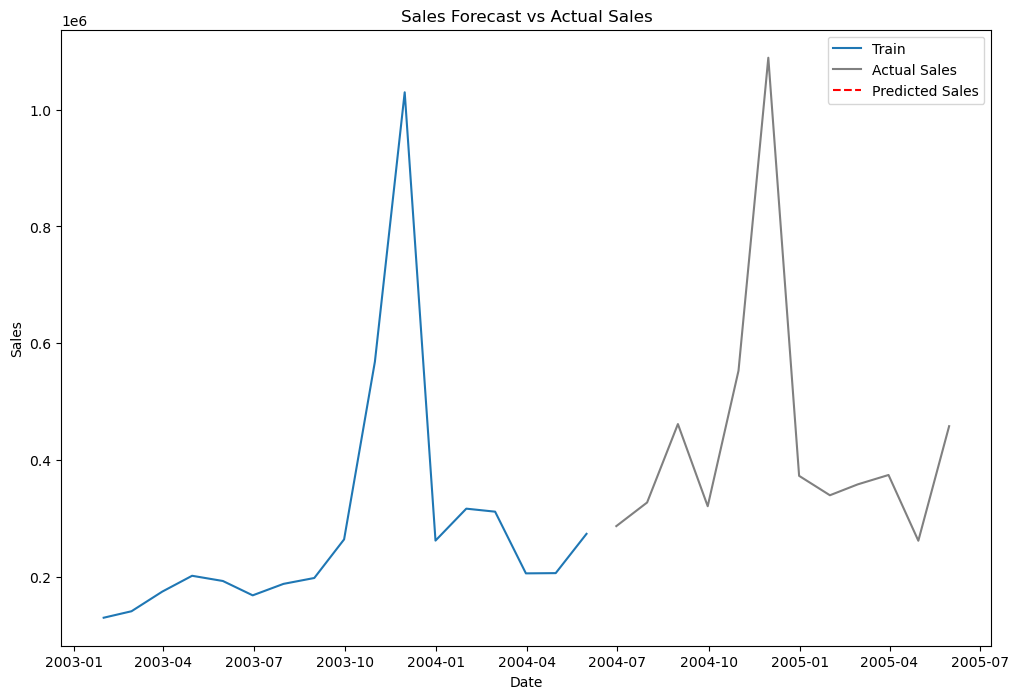

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import itertools
file_path = 'sales_data_sample.csv'

# Load the dataset with a different encoding
try:
    data = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='latin1')

# Convert ORDERDATE to datetime, handling errors
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'], errors='coerce')

# Display the first few rows of the dataframe
print("First few rows of the dataset:")
print(data.head())

# Display summary statistics
print("\nSummary statistics:")
print(data.describe())

# Display data types and missing values
print("\nData types and missing values:")
print(data.info())



# Aggregate sales by date
daily_sales = data.groupby('ORDERDATE')['SALES'].sum()
     


# Check for missing values and fill if necessary
if daily_sales.isna().sum() > 0:
    daily_sales = daily_sales.fillna(method='ffill')  # Forward fill missing values
     

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Aggregate sales by product line
sales_by_product_line = data.groupby('PRODUCTLINE')['SALES'].sum()
     

# Plot sales by product line
plt.figure(figsize=(10, 6))
sales_by_product_line.plot(kind='bar')
plt.title('Total Sales by Product Line')
plt.xlabel('Product Line')
plt.ylabel('Total Sales')
plt.show()

# Prepare data for time series forecasting
data_resampled = daily_sales.resample('M').sum()  # Resample to monthly frequency
     

# Ensure there is enough data for training
if len(data_resampled) < 12:
    raise ValueError("Not enough data to split into train and test sets.")
     

# Split data into train and test sets
train = data_resampled[:-12]
test = data_resampled[-12:]
     

# Perform grid search to find the best ARIMA parameters
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = param
            best_model = results
    except Exception as e:
        print(f"An error occurred for parameters {param}: {e}")
        continue

print(f'Best ARIMA parameters: {best_pdq}')

# Fit ARIMA model with the best parameters
if best_model is None:
    raise ValueError("ARIMA model did not fit any parameters successfully.")

model = ARIMA(train, order=best_pdq)
model_fit = model.fit()
     

# Check model summary
print(model_fit.summary())

# Forecast the next 3 months
forecast_steps = 3
forecast = model_fit.forecast(steps=forecast_steps)
     

# Check if forecast contains NaN values
if pd.isna(forecast).any():
    raise ValueError("Forecasting resulted in NaN values.")

     

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=data_resampled.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
     

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(data=forecast, index=forecast_dates, columns=['Forecast'])
     


# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test', color='gray')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.title('Sales Forecast for the Next 3 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Forecasting plot
plt.figure(figsize=(12, 8))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Actual Sales', color='gray')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Predicted Sales', color='red', linestyle='dashed')
plt.title('Sales Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()